In [1]:
import pandas as pd 
import numpy as np
import torch
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math
import relieff

In [2]:
# data = pd.read_excel('../data/mydata/WTI.xls', header=2, sheet_name="Data 1")
# data.columns = ["Date", "Price"]
# data.index = pd.to_datetime(data["Date"])
# del data["Date"]
# print(data.head(5))

# data = pd.read_csv('../data/澳洲电力负荷数据/NSW2009-2019/NSW2009/DATA200901_NSW1.csv')
# data = pd.read_csv("QLD.csv")

data = pd.read_csv("VIC_all.csv")
# period = [ math.ceil((len(data) / 4)) * i for i in range(0, 5)]
# period[-1] = len(data) + 1
# period[0] = 0
# print(period)
# data.columns = ["Date", "WIND"]
# data.index = pd.to_datetime(data["SETTLEMENTDATE"])
print(len(data))
data = data[["RRP"]]

# data = data.resample('M').sum()
# data = data.to_period('M')
print(data)

4028
             RRP
0      16.577660
1      16.771667
2      17.246875
3      17.321875
4      32.792708
...          ...
4023   62.217292
4024   82.885000
4025  235.758333
4026   45.588958
4027   85.230000

[4028 rows x 1 columns]


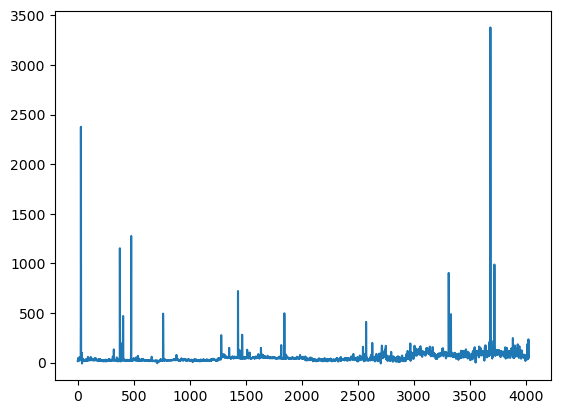

In [3]:
plt.plot(data)
plt.show()

In [4]:
look_back = 1
alpha_1 = 0.10
alpha_2 = 0.10

In [5]:
def create_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data.iloc[i:i + look_back].values.reshape(-1))
        y.append(data.iloc[i + look_back].values.reshape(-1))
    return np.array(X), np.array(y)

In [6]:
X, y = create_data(data, look_back)
init_y = y.copy()

train_size = int(len(X) * 0.7)

X_train = X[:train_size]
y_train = y[:train_size]


from scipy.io import savemat

savemat("X_train.mat", {'X_train': X_train})
savemat("y_train.mat", {'y_train': y_train})

import matlab
import matlab.engine

eng = matlab.engine.start_matlab()
eng.run("./MODA/MODA.m", nargout=0)

from scipy.io import loadmat

if os.path.exists("./params_mean.mat"):
    tmp = loadmat("./params_mean.mat")['params_mean'].reshape(-1)
    alpha_1 = tmp[0]
    alpha_2 = tmp[1]
    print(alpha_1, alpha_2)    
# 将alpha_1, alpha_2保存到csv文件中
parames = pd.DataFrame({"alpha_1": [alpha_1], "alpha_2": [alpha_2]})
parames.to_csv("params.csv", index=False)
exit()
# if os.path.exists("./params_top.mat"):
#     tmp = loadmat("./params_top.mat")['params_top'].reshape(-1)
#     alpha_1 = tmp[0]
#     alpha_2 = tmp[1]
#     print(alpha_1, alpha_2)    

0.3563273806941759 0.7969154011234402


In [7]:
print(X.shape)
print(y.shape)

print(X[:5])
print(y[:5])

(4026, 1)
(4026, 1)
[[16.57765957]
 [16.77166667]
 [17.246875  ]
 [17.321875  ]
 [32.79270833]]
[[16.77166667]
 [17.246875  ]
 [17.321875  ]
 [32.79270833]
 [49.679375  ]]


In [8]:
def create_train_y(data, alpha_1, alpha_2):
    y = []
    for i in range(len(data)):
        value = data[i][0]
        y.append([value * (1 - alpha_1), value * (1 + alpha_2)])
    return np.array(y)

In [ ]:
print(y.shape)

: 

In [ ]:
class myDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor(self.y[idx]).float()
    
batch_size = 32

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.relu(out[:, -1, :])  # Applying ReLU activation
        out = self.fc(out)
        return out


In [ ]:
class My_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pre, y):
        # 输入应该是batch_size * 2 
        return torch.mean(torch.sum(torch.pow((y - y_pre), 2), dim=1))

In [ ]:
def PICP(lower_bound, upper_bound, y):
    return np.sum(np.logical_and(y >= lower_bound, y <= upper_bound)) / len(y)

def PINAW(lower_bound, upper_bound, y):
        return np.mean(upper_bound - lower_bound) / (np.max(y) - np.min(y))

def CWC(picp, pinaw):
    if (picp >= 0.9):
        return 6 * pinaw
    else:
        return (0.1 + 6 * pinaw) * (1 + np.exp(-15 * (picp - 0.9)))

In [ ]:
y = create_train_y(init_y, alpha_1, alpha_2)
scaler = StandardScaler()

train_size = int(len(X) * 0.7)

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

# validation_size = int(len(y_test) * 0.66)

# X_validate = X_test[:validation_size]
# y_validate = y_test[:validation_size]

# X_test = X_test[validation_size:]
# y_test = y_test[validation_size:]

X_train = scaler.fit_transform(X_train)
# X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

my_train_dataset = myDataset(X_train, y_train)
my_train_dataloader = DataLoader(my_train_dataset, batch_size=batch_size, shuffle=False)

# my_validate_dataset = myDataset(X_validate, y_validate)
# my_validate_dataloader = DataLoader(my_validate_dataset, batch_size=batch_size, shuffle=False)

my_test_dataset = myDataset(X_test, y_test)
my_test_dataloader = DataLoader(my_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(y[:3])

[[15.0945     18.44883333]
 [15.5221875  18.9715625 ]
 [15.5896875  19.0540625 ]]


(1208, 2)
(1208, 2)


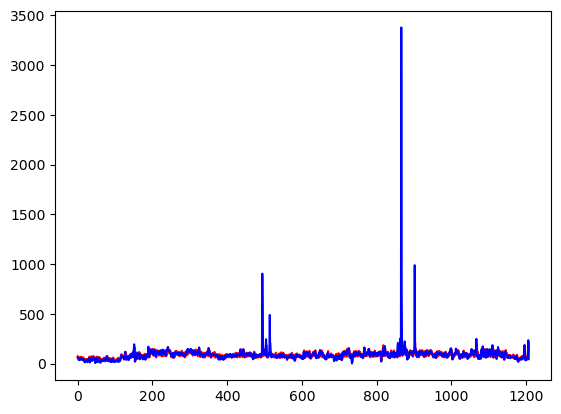

In [ ]:
gru_model = GRU(input_size=1, hidden_size=128, num_layers=2, dropout=0.2)
criterion = My_loss()
optimizer = torch.optim.SGD(gru_model.parameters(), lr=0.002, weight_decay=5e-3)
# optimizer = torch.optim.SGD(gru_model.parameters(), lr=0.01, weight_decay=5e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.4, last_epoch=-1)
num_epochs = 35
min_epoch = 0
min_loss = 9999

train_loss_list = []
validate_loss_list = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(my_train_dataloader):
        inputs = inputs.reshape(len(inputs), look_back, 1)
        outputs = gru_model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # scheduler.step()
    with torch.no_grad():
        train_total_loss = 0
        for inputs, targets in my_train_dataloader:
            inputs = inputs.reshape(len(inputs), look_back, 1)
            outputs = gru_model(inputs)
            train_loss = criterion(outputs, targets)
            train_total_loss += train_loss.item() * len(targets)
        train_loss_list.append(train_total_loss / len(my_train_dataloader))
    # with torch.no_grad():
    #     validate_total_loss = 0
    #     for inputs, targets in my_validate_dataloader:
    #         inputs = inputs.reshape(len(inputs), look_back, 1)
    #         outputs = gru_model(inputs)
    #         validate_loss = criterion(outputs, targets)
    #         if validate_loss < min_loss:
    #             min_loss = validate_loss
    #             min_epoch = epoch
    #         validate_total_loss += validate_loss.item() * len(targets)
    #     validate_loss_list.append(validate_total_loss / len(my_validate_dataloader))
    # print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss_list[-1]}, test_loss={validate_loss_list[-1]}")

# plt.plot(train_loss_list, label='train_loss')
# plt.plot(validate_loss_list, label='test_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

gru_prediction = np.array([])
with torch.no_grad():
    total_loss = 0
    for inputs, targets in my_test_dataloader:
        inputs = inputs.reshape(len(inputs), look_back, 1)
        outputs = gru_model(inputs)
        if len(gru_prediction) == 0:
            gru_prediction = np.array(outputs)
        else:
            gru_prediction = np.concatenate((gru_prediction, outputs), axis=0)
print(gru_prediction.shape)
print(y_test.shape)

plt.plot(gru_prediction[:, 0], 'r')
plt.plot(gru_prediction[:, 1], 'r')
plt.plot(init_y[train_size:], 'b')
plt.show()

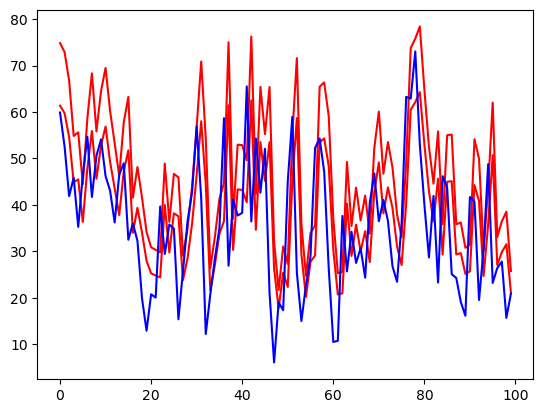

In [ ]:

plt.plot(gru_prediction[:, 0][:100], 'r')
plt.plot(gru_prediction[:, 1][:100], 'r')
plt.plot(init_y[train_size:][:100], 'b')
plt.show()

In [ ]:
picp = PICP(gru_prediction[:, 0], gru_prediction[:, 1], init_y[train_size:].reshape(-1))
pinaw = PINAW(gru_prediction[:, 0], gru_prediction[:, 1], init_y[train_size:].reshape(-1))
cwc = CWC(picp, pinaw)

print(picp)
print(pinaw)

0.3468543046357616
0.00507231727741663


In [ ]:
# record_pd = pd.DataFrame(columns=["PICP-优化", "PINAW-优化", "CWC-优化", "alpha1-优化", "alpha2-优化", "PICP", "PINAW", "CWC", "alpha1", "alpha2"])
# if os.path.exists("record_index.xlsx"):
#       record_pd = pd.read_excel("record_index.xlsx")
# print(record_pd)
# record_pd.loc[len(record_pd)] = [picp_, pinaw_, cwc_, record_alpha_1, record_alpha_2, picp, pinaw, cwc, alpha_1, alpha_2]
record_pd = pd.DataFrame(columns=["PICP", "PINAW", "CWC", "alpha1", "alpha2"])
if os.path.exists("record_index.xlsx"):
      record_pd = pd.read_excel("record_index.xlsx")
print(record_pd)
record_pd.loc[len(record_pd)] = [picp, pinaw, cwc, alpha_1, alpha_2]

       PICP     PINAW           CWC  alpha1  alpha2
0  0.000000 -0.000012  72887.734395     0.0     0.0
1  0.000000 -0.000016  72871.842510     0.0     0.0
2  0.971026  0.036649      0.219894     0.8     0.8
3  0.000828 -0.000021  71952.194139     0.0     0.0
4  0.688742  0.014553      4.641871     0.3     0.3
5  0.666391  0.013754      6.251947     0.3     0.3
6  0.725166  0.014137      2.729916     0.3     0.3
7  0.307119  0.004712    934.240475     0.1     0.1
8  0.355960  0.004822    451.424791     0.1     0.1


In [ ]:
record_pd.to_excel("record_index.xlsx", index=False)

In [ ]:
record_pd = pd.read_excel("record_index.xlsx")

In [ ]:
record_pd

,PICP,PINAW,CWC,alpha1,alpha2
0,0.000000,-0.000012,72887.734395,0.0,0.0
1,0.000000,-0.000016,72871.842510,0.0,0.0
2,0.971026,0.036649,0.219894,0.8,0.8
3,0.000828,-0.000021,71952.194139,0.0,0.0
4,0.688742,0.014553,4.641871,0.3,0.3
5,0.666391,0.013754,6.251947,0.3,0.3
6,0.725166,0.014137,2.729916,0.3,0.3
7,0.307119,0.004712,934.240475,0.1,0.1
8,0.355960,0.004822,451.424791,0.1,0.1
9,0.346854,0.005072,523.504670,0.1,0.1
